# Forecasting Bike Rental Demand in SF

Bike Sharing System is a modern way to rent bikes and its commonly used in metropolitan cities like San Francisco, New York City, and Washington DC. The process of obtaining membership, renting and returning bikes is automated through networks throughout the city. Using these systems, people can rent a bike from one place and return it to another as needed. Currently, there are more than 500 bike-sharing programs worldwide.

These systems generate a lot of data related to the duration of travel, departure location, arrival location, and time elapsed, which is very useful for study city mobility. Also, understand what factor (like weather, traffic, hourly/daily trend) affects the number of bike rentals will help cities make a better business strategy like how is bikes and docks availability on each station or where future bike stations should be installed.

In [1]:
# General
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import math


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

# Data Wrangling

In [2]:
#load and explore trip dataset
trip= pd.read_csv('trip.csv')

In [3]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [4]:
# check datatypes
trip.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [5]:
# check missing values
trip.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [6]:
# change start_date and end_date to datetime formate
trip['start_date']= pd.to_datetime(trip['start_date'],format='%m/%d/%Y %H:%M')
trip['end_date']= pd.to_datetime(trip['end_date'],format='%m/%d/%Y %H:%M')

In [7]:
# change duration from secondes to minutes
trip.duration = trip.duration/60

In [8]:
# check the duration outliers
trip.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

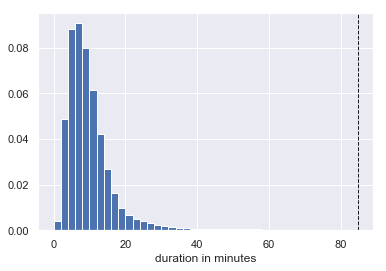

In [9]:
sns.set()
plt.hist(trip.duration,normed=True,bins=range(0,60,2))
plt.axvline(np.percentile(trip.duration,97.5), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('duration in minutes')
plt.show()

In [10]:
# remove outliers for trip duration more than 1 hour
trip = trip[trip.duration<=60]

In [11]:
# add some new columns for EDA 
trip['date']=trip['start_date'].dt.date
trip['day']=trip['start_date'].dt.dayofweek
trip['hour']=trip['start_date'].dt.hour
trip['month']=trip['start_date'].dt.month
trip['week']=trip['start_date'].dt.week

In [12]:
# rename columns day and month
trip.day= trip.day.map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
trip.month = trip.month.map({1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'})

In [13]:
# add holiday columns
cal = calendar()
holidays = cal.holidays(start = trip.date.min(),end=trip.date.max())
trip['holiday']= trip.date.apply(lambda x: x in(holidays))

In [14]:
# add workingday columns
workingday = ['Monday','Tuesday','Wednesday','Thursday','Friday']
trip['workingday']=trip.day.isin(workingday)

In [15]:
# delte unuseful columns and change some columns datatype
trip.drop(['id','bike_id','zip_code'],axis=1,inplace=True)
for col in ['start_station_name','start_station_id','end_station_name','end_station_id','subscription_type','date','day','hour','week','month','week','holiday','workingday']:
    trip[col]=trip[col].astype('category')

In [16]:
# check the dataset after modify
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648717 entries, 0 to 669958
Data columns (total 15 columns):
duration              648717 non-null float64
start_date            648717 non-null datetime64[ns]
start_station_name    648717 non-null category
start_station_id      648717 non-null category
end_date              648717 non-null datetime64[ns]
end_station_name      648717 non-null category
end_station_id        648717 non-null category
subscription_type     648717 non-null category
date                  648717 non-null category
day                   648717 non-null category
hour                  648717 non-null category
month                 648717 non-null category
week                  648717 non-null category
holiday               648717 non-null category
workingday            648717 non-null category
dtypes: category(12), datetime64[ns](2), float64(1)
memory usage: 27.9 MB


In [17]:
trip.head()

,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,subscription_type,date,day,hour,month,week,holiday,workingday
0,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,Subscriber,2013-08-29,Thursday,14,August,35,False,True
1,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,14,August,35,False,True
2,1.183333,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,Subscriber,2013-08-29,Thursday,10,August,35,False,True
3,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,11,August,35,False,True
4,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,Subscriber,2013-08-29,Thursday,12,August,35,False,True


In [18]:
# load and explore station file
station= pd.read_csv('station.csv')

In [19]:
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [20]:
# check datatypes
station.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [21]:
# check missing values
station.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

In [22]:
# change columns dtype
for col in ['name','city']:
    station[col]=station[col].astype('category')

In [23]:
# convert installation_date to datetime formate
station['installation_date']=pd.to_datetime(station.installation_date)

In [24]:
# load and explore weather file
weather = pd.read_csv('weather.csv')

In [25]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [26]:
#check datatypes
weather.dtypes

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches               object
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                          

In [27]:
# check missing values
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [28]:
# convert date column in datatime formate
weather['date'] = pd.to_datetime(weather.date)

In [29]:
# set date column as index, prepare for filling missing values
weather = weather.set_index('date', drop=True)

In [30]:
# check events column
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [31]:
# check which event is more severe by compared the mean_visibility_miles and mean_wind_speed_mhp
weather.loc[weather.events == 'rain','events'] ='Rain'
weather.loc[weather.events.isnull(),'events'] ='Normal'
events_severe = {'mean_visibility_miles':[weather[weather.events=='Normal'].mean_visibility_miles.mean(),weather[weather.events=='Fog'].mean_visibility_miles.mean(),weather[weather.events=='Fog-Rain'].mean_visibility_miles.mean(),weather[weather.events=='Rain'].mean_visibility_miles.mean(),weather[weather.events=='Rain-Thunderstorm'].mean_visibility_miles.mean()],'mean_wind_speed_mph':[weather[weather.events=='Normal'].mean_wind_speed_mph.mean(),weather[weather.events=='Fog'].mean_wind_speed_mph.mean(),weather[weather.events=='Fog-Rain'].mean_wind_speed_mph.mean(),weather[weather.events=='Rain'].mean_wind_speed_mph.mean(),weather[weather.events=='Rain-Thunderstorm'].mean_wind_speed_mph.mean()]}

In [32]:
events = pd.DataFrame(events_severe,index=['Normal','Fog','Fog-Rain','Rain','Rain-Thunderstorm'])

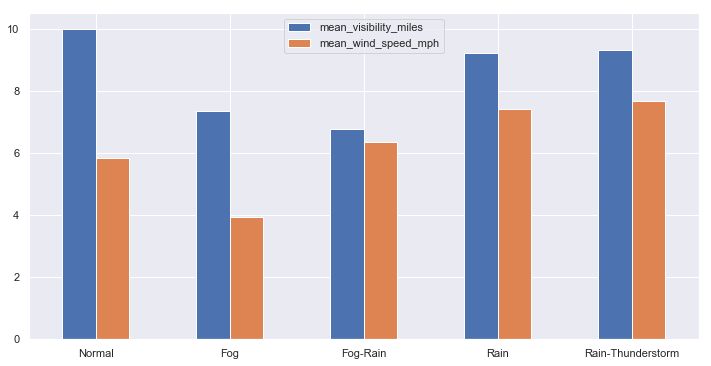

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
events.plot(ax=ax,kind='bar')
plt.xticks(rotation=360)
plt.show()

In [34]:
# write events properly and labeled them in numbers
weather.events = weather.events.map({'Normal':0,'Fog':1,'Rain':2,'Rain-Thunderstorm':3,'Fog-Rain':4})

In [35]:
# convert traces of rain to .001 inches of rain to recognize that there was perciptation but it was a value less than what could be measured.
weather.loc[weather.precipitation_inches=='T','precipitation_inches']= 0.001

In [36]:
# convert objects columns to numeric values and fill na with its own average
weather = weather.convert_objects(convert_numeric=True)
weather = weather.fillna(weather.mean())

In [37]:
# check dataframe after modify
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3665 entries, 2013-08-29 to 2015-08-31
Data columns (total 23 columns):
max_temperature_f                 3665 non-null float64
mean_temperature_f                3665 non-null float64
min_temperature_f                 3665 non-null float64
max_dew_point_f                   3665 non-null float64
mean_dew_point_f                  3665 non-null float64
min_dew_point_f                   3665 non-null float64
max_humidity                      3665 non-null float64
mean_humidity                     3665 non-null float64
min_humidity                      3665 non-null float64
max_sea_level_pressure_inches     3665 non-null float64
mean_sea_level_pressure_inches    3665 non-null float64
min_sea_level_pressure_inches     3665 non-null float64
max_visibility_miles              3665 non-null float64
mean_visibility_miles             3665 non-null float64
min_visibility_miles              3665 non-null float64
max_wind_Speed_mph                3

In [38]:
weather.reset_index(inplace=True)

In [39]:
# check unique zip_code
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [40]:
# convert zip_code to city name
zipcode_city = dict({94107:'San Francisco',94063:'Redwood City',94301:'Palo Alto',94041:'Mountain View',95113:'San Jose'})
weather['city'] = weather.zip_code.apply(lambda x: zipcode_city[x])

In [41]:
# add new column 'week'
weather['week']=weather.date.dt.week

In [42]:
# convert column datatype
for col in ['city','date','week']:
    weather[col] = weather[col].astype('category')

In [43]:
# drop unnecessary column
weather = weather.drop(['zip_code'],axis=1)

In [44]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664
Data columns (total 25 columns):
date                              3665 non-null category
max_temperature_f                 3665 non-null float64
mean_temperature_f                3665 non-null float64
min_temperature_f                 3665 non-null float64
max_dew_point_f                   3665 non-null float64
mean_dew_point_f                  3665 non-null float64
min_dew_point_f                   3665 non-null float64
max_humidity                      3665 non-null float64
mean_humidity                     3665 non-null float64
min_humidity                      3665 non-null float64
max_sea_level_pressure_inches     3665 non-null float64
mean_sea_level_pressure_inches    3665 non-null float64
min_sea_level_pressure_inches     3665 non-null float64
max_visibility_miles              3665 non-null float64
mean_visibility_miles             3665 non-null float64
min_visibility_miles              3665 non-null floa

# Exploratory data analysis

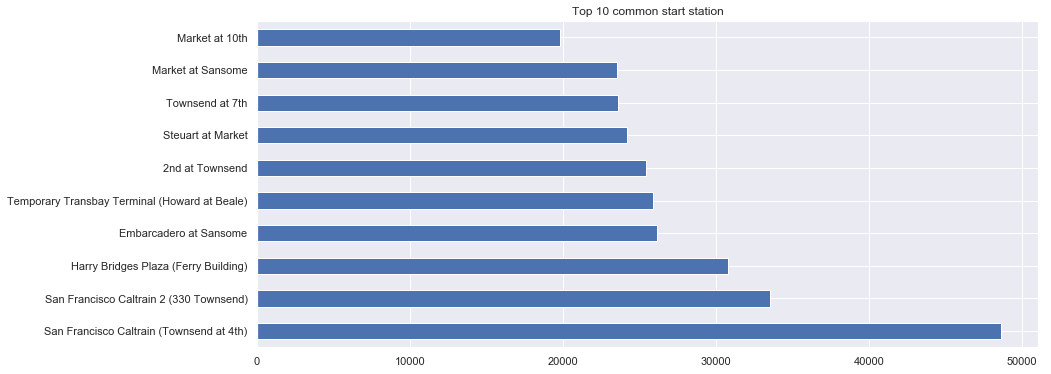

In [45]:
# top 10 common start station
trip['start_station_name'].value_counts().head(10).plot(kind='barh',figsize=(14,6))
plt.title('Top 10 common start station')
plt.show()

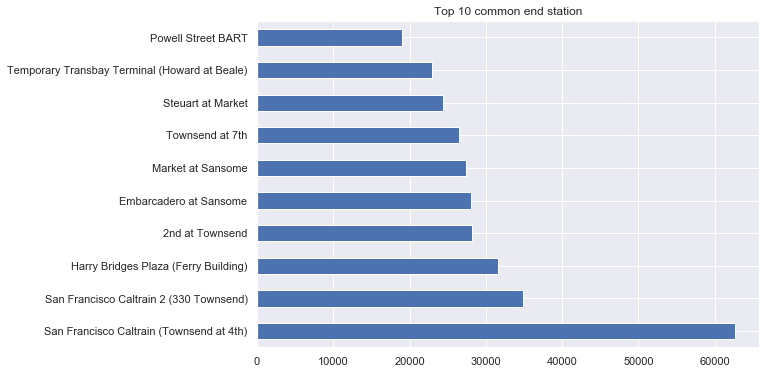

In [46]:
# top 10 common end station
trip['end_station_name'].value_counts().head(10).plot(kind='barh',figsize=(9,6))
plt.title('Top 10 common end station')
plt.show()

In [47]:
trip.subscription_type= trip.subscription_type.map({'Subscriber':'Subscriber',"Customer":'No Subscriber'})

In [48]:
# anuual trip_counts by user type
total_count =trip.groupby(['date','subscription_type']).size().to_frame('count').reset_index()

In [49]:
total_count.head()

,date,subscription_type,count
0,2013-08-29,No Subscriber,262
1,2013-08-29,Subscriber,456
2,2013-08-30,No Subscriber,333
3,2013-08-30,Subscriber,305
4,2013-08-31,No Subscriber,380


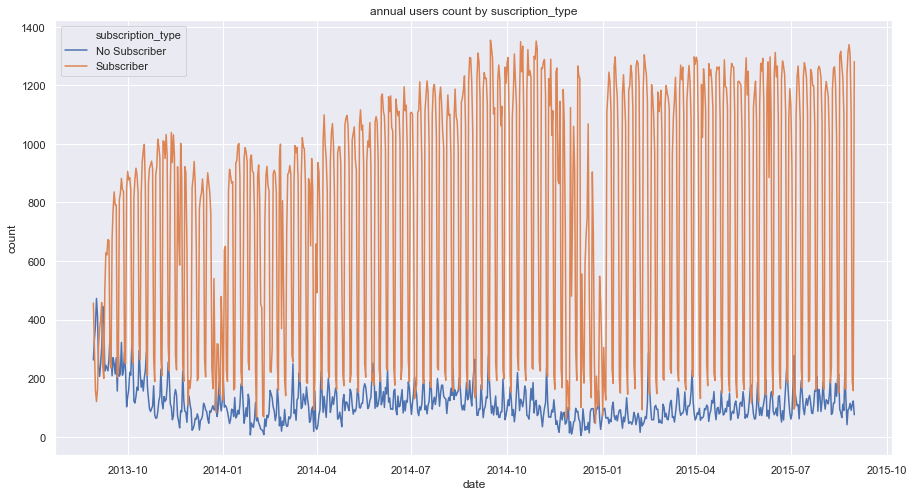

In [50]:
plt.figure(figsize=(15,8))
sns.lineplot(x='date',y='count',hue ='subscription_type',data=total_count)
plt.title('annual users count by suscription_type')
plt.show()


In [51]:
# total uesrs count by workingdays
workingday = trip.groupby(['workingday','subscription_type']).size()
workingday = workingday.unstack('subscription_type')

In [52]:
workingday.head()

subscription_type,No Subscriber,Subscriber
workingday,,
False,32392,41172
True,51235,523918


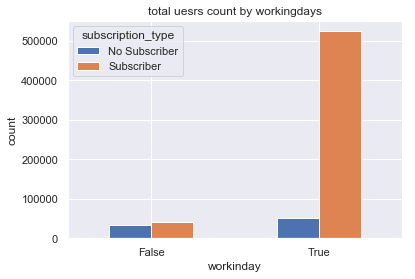

In [53]:
workingday.plot(kind='bar')
plt.xlabel('workinday')
plt.ylabel('count')
plt.xticks(rotation=360)
plt.title('total uesrs count by workingdays')
plt.show()

In [54]:
# total uesrs count by holidays
holiday = trip.groupby(['holiday','subscription_type']).size()
holiday = holiday.unstack('subscription_type')

In [55]:
holiday

subscription_type,No Subscriber,Subscriber
holiday,,
False,80790,557889
True,2837,7201


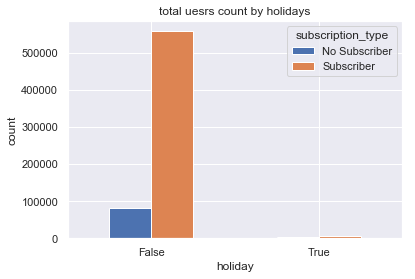

In [56]:
holiday.plot(kind='bar')
plt.xlabel('holiday')
plt.ylabel('count')
plt.xticks(rotation=360)
plt.title('total uesrs count by holidays')
plt.show()

In [57]:
# total counts by month

In [58]:
monthly_count = trip.groupby('month').size().to_frame('count').reset_index()

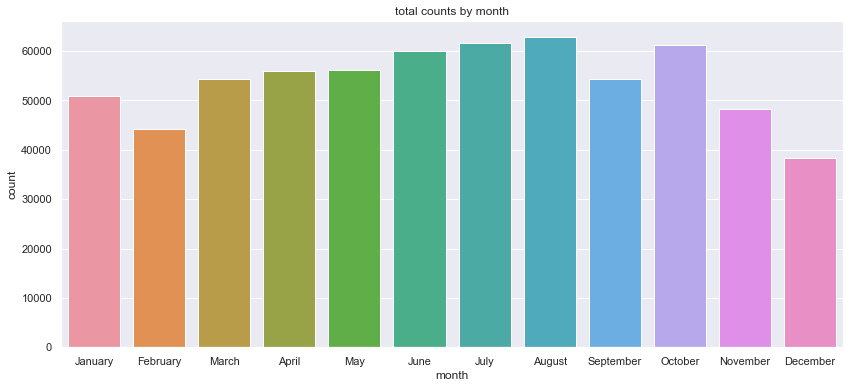

In [59]:
plt.figure(figsize=(14,6))
monthOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
sns.barplot(data=monthly_count, x="month", y="count",order=monthOrder)
plt.title('total counts by month')
plt.show()

In [60]:
# total counts by hour of the day across weekdays

In [61]:
hourly_count = trip.groupby(['hour','day']).size().to_frame('count').reset_index()

In [62]:
hourly_count.head()

,hour,day,count
0,0,Friday,290
1,0,Monday,162
2,0,Saturday,451
3,0,Sunday,439
4,0,Thursday,266


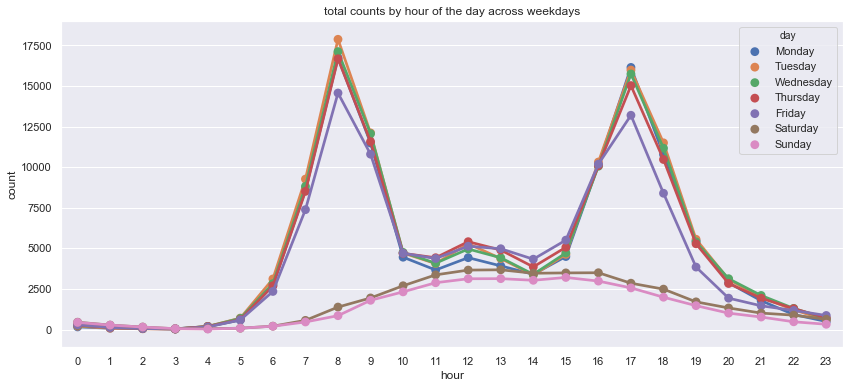

In [63]:
plt.figure(figsize=(14,6))
weekOrder =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.pointplot(x='hour',y='count',hue ='day',hue_order= weekOrder,data=hourly_count)
plt.title('total counts by hour of the day across weekdays')
plt.show()

In [64]:
# total counts by hour of the day across subscription_type

In [65]:
hourly = trip.groupby(['hour','subscription_type']).size().to_frame('count').reset_index()

In [66]:
hourly.head()

,hour,subscription_type,count
0,0,No Subscriber,561
1,0,Subscriber,1498
2,1,No Subscriber,398
3,1,Subscriber,679
4,2,No Subscriber,244


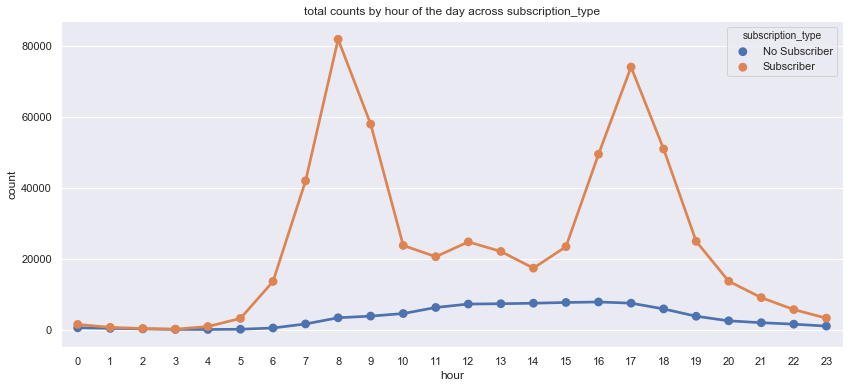

In [67]:
plt.figure(figsize=(14,6))
sns.pointplot(x='hour',y='count',hue ='subscription_type',data=hourly)
plt.title('total counts by hour of the day across subscription_type')
plt.show()

After grouping riders by subscription type (Subscriber: monthly or annual member, and Customer: casual pay-as-you-go rider), I explored seasonal, weekly, and daily ridership patterns. All timeframes highlight distinct patterns for Subscribers vs. Customers, supporting the hypothesis that Subscribers are commuters and Customers are largely tourists.

Excluding holidays, ridership increases slightly in the first half of the year, peaking in summer (week 34/35) in ideal bike weather. rides start to drop off in the Fall.

Subscriber ridership has a large drop on holidays and weekends, also show a distinct bi-modal daily usage pattern, with peaks during AM & PM commute hours, and a small increase during lunch.

Customers ridership shows seasonal patterns, peaking in Aug/Sept/Oct and with a lull around the holidays. For daily usage, Customers get a later start (as one does on vacation), with steady usage 11am until the early evening.

In [68]:
# merging trip dataframe with station and weather dataframe

In [69]:
# rename and drop columns
station.rename(columns = {'name':'station_name'},inplace=True)
station.drop(['id','lat','long','installation_date'],axis=1,inplace=True)

In [70]:
station.head()

,station_name,dock_count,city
0,San Jose Diridon Caltrain Station,27,San Jose
1,San Jose Civic Center,15,San Jose
2,Santa Clara at Almaden,11,San Jose
3,Adobe on Almaden,19,San Jose
4,San Pedro Square,15,San Jose


In [71]:
trip.head()

,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,subscription_type,date,day,hour,month,week,holiday,workingday
0,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,Subscriber,2013-08-29,Thursday,14,August,35,False,True
1,1.166667,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,14,August,35,False,True
2,1.183333,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,Subscriber,2013-08-29,Thursday,10,August,35,False,True
3,1.283333,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,Subscriber,2013-08-29,Thursday,11,August,35,False,True
4,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,Subscriber,2013-08-29,Thursday,12,August,35,False,True


In [72]:
# create a DataFrame for machine learning 
df = trip.groupby(['date','start_station_name','holiday','workingday']).size().to_frame('trip_count').reset_index()
df.rename(columns={'start_station_name':'station_name'},inplace=True)

In [73]:
df.head()

,date,station_name,holiday,workingday,trip_count
0,2013-08-29,2nd at Folsom,False,True,12
1,2013-08-29,2nd at South Park,False,True,11
2,2013-08-29,2nd at Townsend,False,True,8
3,2013-08-29,5th at Howard,False,True,12
4,2013-08-29,Adobe on Almaden,False,True,3


In [74]:
# merge with station dataset
df = df.merge(station, how ='left',on='station_name')

In [75]:
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose


In [76]:
# check missing value
df.isnull().sum()

date               0
station_name       0
holiday            0
workingday         0
trip_count         0
dock_count      1150
city            1150
dtype: int64

In [77]:
# check the missing station name and which city it belongs
df[df.city.isnull()].station_name.value_counts()

Washington at Kearny          544
Post at Kearny                543
Broadway at Main               49
San Jose Government Center     14
Name: station_name, dtype: int64

In [78]:
station_name_city = dict({'Washington at Kearny':'San Francisco','Post at Kearny':'San Francisco','Broadway at Main':'Redwood City','San Jose Government Center':'San Jose'})

In [79]:
# fiiling the city based on the location of station_name and filling dock count with overall dock mean value
df.city.fillna(df[df.city.isnull()].station_name.apply(lambda x:station_name_city[x]),inplace=True)
df.dock_count.fillna(df.dock_count.mean(),inplace=True)

In [80]:
#merge with weather

In [81]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,city,week
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,San Francisco,35
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,7.0,29.0,13.0,35.0,0.0,2.0,0,291.0,San Francisco,35
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,26.0,15.0,31.0,0.0,4.0,0,284.0,San Francisco,35
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,25.0,13.0,29.0,0.0,4.0,0,284.0,San Francisco,35
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,6.0,23.0,12.0,30.0,0.0,6.0,0,277.0,San Francisco,36


In [82]:
# check df dataframe
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose


In [83]:
# merge with weather
df = df.merge(weather,how='left',on=['date','city'] )

In [84]:
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,week
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,0,286.0,35
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose,81.0,72.0,63.0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,0,320.0,35


In [85]:
# check missing value
df.isnull().sum()

date                              0
station_name                      0
holiday                           0
workingday                        0
trip_count                        0
dock_count                        0
city                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
events                      

In [86]:
# check dtypes
df.dtypes

date                              category
station_name                        object
holiday                           category
workingday                        category
trip_count                           int64
dock_count                         float64
city                              category
max_temperature_f                  float64
mean_temperature_f                 float64
min_temperature_f                  float64
max_dew_point_f                    float64
mean_dew_point_f                   float64
min_dew_point_f                    float64
max_humidity                       float64
mean_humidity                      float64
min_humidity                       float64
max_sea_level_pressure_inches      float64
mean_sea_level_pressure_inches     float64
min_sea_level_pressure_inches      float64
max_visibility_miles               float64
mean_visibility_miles              float64
min_visibility_miles               float64
max_wind_Speed_mph                 float64
mean_wind_s

In [87]:
for col in ['station_name','events']:
    df[col] = df[col].astype('category')

In [88]:
# how events affects trip counts
df.events = df.events.map({0:'Normal',1:'Fog',2:'Rain',3:'Rain-Thunderstorm',4:'Fog-Rain'})
events = df.groupby(['events','week']).trip_count.sum().to_frame('count').reset_index()
events.head(10)

,events,week,count
0,Fog,1,1334
1,Fog,2,585
2,Fog,3,3885
3,Fog,4,1163
4,Fog,5,3903
5,Fog,6,1245
6,Fog,7,3090
7,Fog,8,218
8,Fog,9,1058
9,Fog,10,689


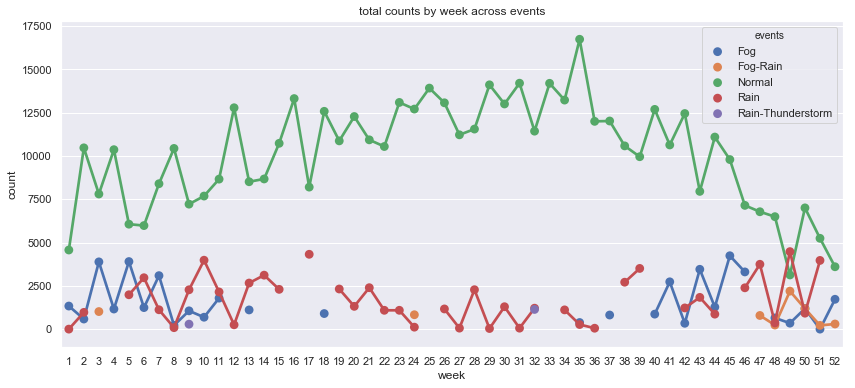

In [89]:
plt.figure(figsize=(14,6))
sns.pointplot(x='week',y='count',hue='events',data=events)
plt.title('total counts by week across events')
plt.show()

In [90]:
# how temperature affect trip counts
temperature_count = df.groupby(['mean_temperature_f','city','workingday']).trip_count.sum().to_frame('count').reset_index()
temperature_count.head(10)

,mean_temperature_f,city,workingday,count
0,38.0,Mountain View,False,8
1,38.0,Mountain View,True,59
2,38.0,San Jose,True,57
3,39.0,Palo Alto,False,2
4,39.0,San Jose,False,17
5,40.0,Palo Alto,True,19
6,41.0,Mountain View,True,21
7,41.0,Palo Alto,True,11
8,41.0,Redwood City,True,4
9,41.0,San Francisco,True,365


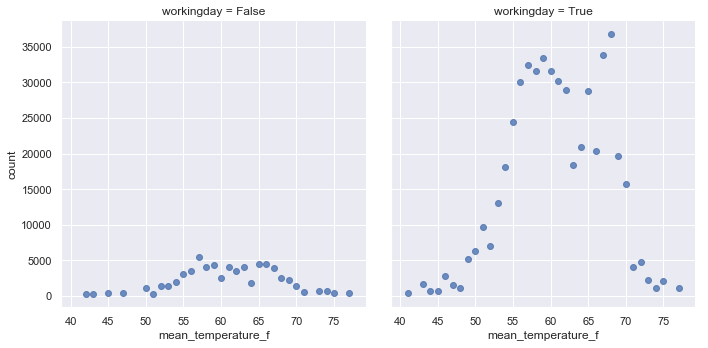

In [91]:
sns.lmplot('mean_temperature_f','count',col='workingday',data=temperature_count[temperature_count.city=='San Francisco'],fit_reg=False)

In [92]:
# how wind speed affect trip counts
wind_count = df.groupby(['mean_wind_speed_mph','city','workingday']).trip_count.sum().to_frame('count').reset_index()

In [93]:
wind_count.head()

,mean_wind_speed_mph,city,workingday,count
0,0.0,Mountain View,False,25
1,0.0,Mountain View,True,67
2,0.0,Redwood City,False,3
3,0.0,Redwood City,True,61
4,0.0,San Francisco,True,974


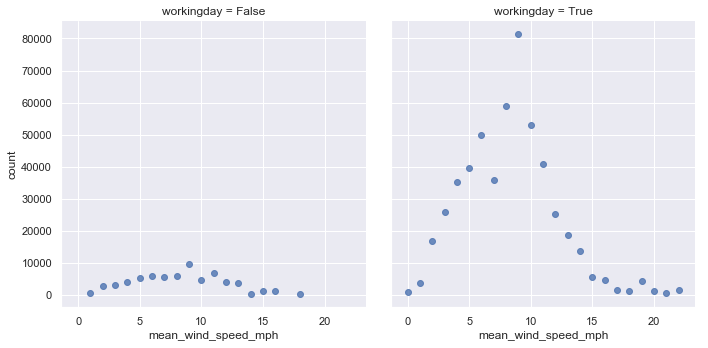

In [94]:
sns.lmplot('mean_wind_speed_mph','count',col='workingday',data=wind_count[wind_count.city=='San Francisco'],fit_reg=False)

In [95]:
# how visibility affect trip counts
wind_count = df.groupby(['mean_visibility_miles','city','workingday']).trip_count.sum().to_frame('count').reset_index()

In [96]:
wind_count.head()

,mean_visibility_miles,city,workingday,count
0,4.0,Mountain View,False,7
1,4.0,Mountain View,True,3
2,4.0,Palo Alto,True,31
3,4.0,Redwood City,True,8
4,4.0,San Francisco,True,3029


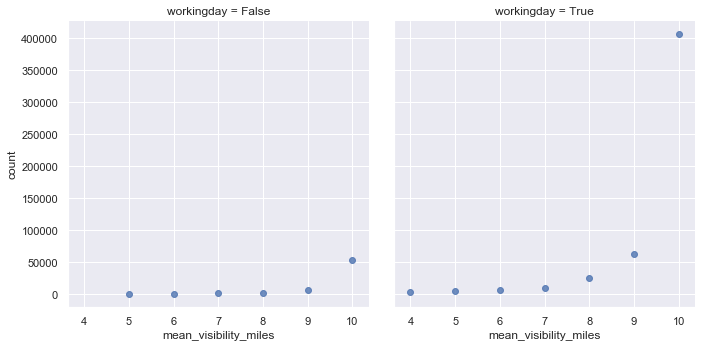

In [97]:
sns.lmplot('mean_visibility_miles','count',col='workingday',data=wind_count[wind_count.city=='San Francisco'],fit_reg=False)

There is no clear relationship between each weather features and daily trips. obviously, people are willing to use a bike rental service on a normal day rather than fog or raining day. The trip counts have no significant difference between fog and rain, but we can see there is more fog weather in wintertime them summer.

Higher the temperature, the more people choose to bike to work. when the wind speed increases more than 10 mph, the trip count starts to reduce. And visibility seems not a key feature for trip counts.

# Machine Learning

In [98]:
# check the dataframe
df.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,week
0,2013-08-29,2nd at Folsom,False,True,12,19.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,Normal,286.0,35
1,2013-08-29,2nd at South Park,False,True,11,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,Normal,286.0,35
2,2013-08-29,2nd at Townsend,False,True,8,27.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,Normal,286.0,35
3,2013-08-29,5th at Howard,False,True,12,15.0,San Francisco,74.0,68.0,61.0,...,10.0,10.0,23.0,11.0,28.0,0.0,4.0,Normal,286.0,35
4,2013-08-29,Adobe on Almaden,False,True,3,19.0,San Jose,81.0,72.0,63.0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,Normal,320.0,35


In [99]:
# the 10 most popular stations
trip['start_station_name'].value_counts().head(10)

San Francisco Caltrain (Townsend at 4th)         48616
San Francisco Caltrain 2 (330 Townsend)          33488
Harry Bridges Plaza (Ferry Building)             30778
Embarcadero at Sansome                           26114
Temporary Transbay Terminal (Howard at Beale)    25884
2nd at Townsend                                  25427
Steuart at Market                                24180
Townsend at 7th                                  23571
Market at Sansome                                23524
Market at 10th                                   19777
Name: start_station_name, dtype: int64

In [100]:
# get dummies variables on events column
df = pd.get_dummies(df,columns=['events'],drop_first= True)

In [101]:
# choose the 'San Francisco Caltrain (Townsend at 4th)' as my target station
df1 = df[df.station_name =='San Francisco Caltrain (Townsend at 4th)']

In [102]:
df1.head()

,date,station_name,holiday,workingday,trip_count,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,week,events_Fog-Rain,events_Normal,events_Rain,events_Rain-Thunderstorm
41,2013-08-29,San Francisco Caltrain (Townsend at 4th),False,True,30,19.0,San Francisco,74.0,68.0,61.0,...,11.0,28.0,0.0,4.0,286.0,35,0,1,0,0
102,2013-08-30,San Francisco Caltrain (Townsend at 4th),False,True,25,19.0,San Francisco,78.0,69.0,60.0,...,13.0,35.0,0.0,2.0,291.0,35,0,1,0,0
160,2013-08-31,San Francisco Caltrain (Townsend at 4th),False,False,13,19.0,San Francisco,71.0,64.0,57.0,...,15.0,31.0,0.0,4.0,284.0,35,0,1,0,0
214,2013-09-01,San Francisco Caltrain (Townsend at 4th),False,False,22,19.0,San Francisco,74.0,66.0,58.0,...,13.0,29.0,0.0,4.0,284.0,35,0,1,0,0
269,2013-09-02,San Francisco Caltrain (Townsend at 4th),True,True,20,19.0,San Francisco,75.0,69.0,62.0,...,12.0,30.0,0.0,6.0,277.0,36,0,1,0,0


In [103]:
#Convert True to 1 and False to 0
df1.workingday = df1.workingday.map(lambda x: 1 if x == True else 0)
df1.holiday = df1.holiday.map(lambda x: 1 if x == True else 0)

In [104]:
#set test,train values
test = df1.trip_count
train=df1.drop(['date','trip_count','station_name','city'],axis=1)

In [105]:
# train_test split
X_train,X_test,y_train,y_test = train_test_split(train,test,test_size=0.33,random_state=42 )

In [106]:
# GridSearch
def Gridsearchcv(model,grid):
    model = GridSearchCV(model,grid,scoring='neg_mean_absolute_error',cv=5)
    model.fit(X_train,y_train)
    print('best parameter:{}'.format(model.best_params_),'best score:{}'.format(model.best_score_))

In [107]:
#Used mean absolute error to learn how many trips my predictions are off by.Multiply by -1 to make values positive.
def scoring(regressor):
    score = cross_val_score(regressor, X_train, y_train, cv=15, scoring = 'neg_mean_absolute_error')
    return np.mean(score) * -1

Random Forest

In [108]:
rfr = RandomForestRegressor(random_state=42)
random_grid={'min_samples_leaf':[2,3,4],
            'n_estimators':[50,70,100]}

In [109]:
Gridsearchcv(rfr,random_grid)

best parameter:{'min_samples_leaf': 3, 'n_estimators': 50} best score:-11.947155679014863


In [110]:
rfr_1=RandomForestRegressor(n_estimators=50,min_samples_leaf=3,random_state=42)

Decision Tree

In [111]:
dtr=DecisionTreeRegressor(random_state=42)
tree_grid={'min_samples_leaf':[2,3,4],
          'max_depth':[4,6,8]}

In [112]:
Gridsearchcv(dtr,tree_grid)

best parameter:{'max_depth': 6, 'min_samples_leaf': 4} best score:-13.213479664726478


In [113]:
dtr_1 = DecisionTreeRegressor(min_samples_leaf=4,max_depth=6,random_state=42)

Linear Regression

In [114]:
lr = LinearRegression()

Gradient Boosting

In [115]:
gbr=GradientBoostingRegressor(random_state=42)
boost_grid={'learning_rate':[0.01,0.1,0.5],
           'n_estimators':[50,100,150],
           'max_depth':[2,4,6],
           'min_samples_leaf':[1,2,3]}

In [116]:
Gridsearchcv(gbr,boost_grid)

best parameter:{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 50} best score:-12.311448671736768


In [117]:
gbr_1=GradientBoostingRegressor(learning_rate=0.1,n_estimators=50,min_samples_leaf=3,max_depth=6,random_state=42)


AdaBoost

In [118]:
abr=AdaBoostRegressor(random_state=42)
aboost_grid={'learning_rate':[0.01,0.1,0.5],
            'n_estimators':[50,100,150]}

In [119]:
Gridsearchcv(abr,aboost_grid)

best parameter:{'learning_rate': 0.01, 'n_estimators': 50} best score:-13.194424103701499


In [120]:
abr_1 =AdaBoostRegressor(learning_rate=0.01,n_estimators=50,random_state=42)

In [121]:
# compare prediction on different models
data = {'neg_mean_absolute_error':[scoring(rfr_1),scoring(dtr_1),scoring(lr),scoring(gbr_1),scoring(abr_1)]}
compare = pd.DataFrame(data,index=['Random Forest','Decision Tree','Linear Regression','Gradient Boosting','AdaBoost'])

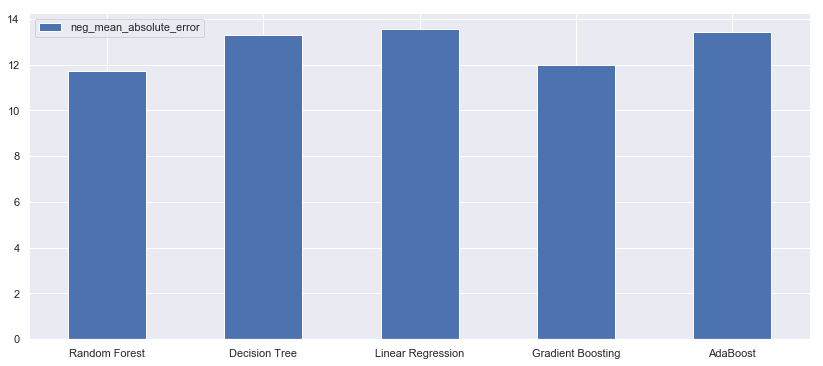

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))
compare.plot(ax=ax,kind='bar')
plt.xticks(rotation=360)
plt.show()

In [123]:
# predict the number of trips using the best model-random forest regressor
rfr_1.fit(X_train,y_train)
predicted=rfr_1.predict(X_test)

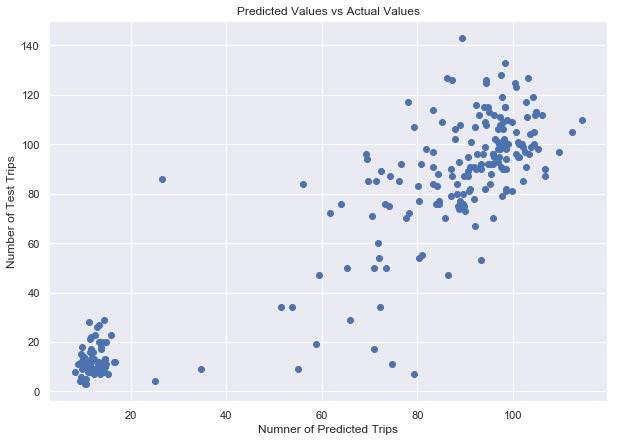

In [124]:
# scatter plot on predict values and test values
plt.figure(figsize=(10,7))
plt.scatter(x=predicted,y=y_test)
plt.ylabel("Number of Test Trips")
plt.xlabel("Numner of Predicted Trips")
plt.title("Predicted Values vs Actual Values")
plt.show()

## Feature Importance

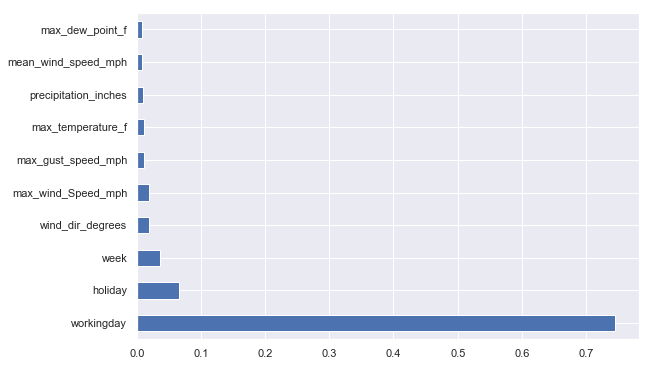

In [125]:
plt.figure(figsize=(9,6))
feature_importance = pd.Series(rfr_1.feature_importances_,index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

I believe I have made a good model to predict daily trips that will take with the bike-sharing service at a particular station. The mean absolute error of my model is about 11 times a day. 
The company could use my model to predict any station usage they are looking for and get a good rough estimate of the dock account they should keep for each day.

To make the model more accurate and usable, the next step I will focus on the larger number of trips, especially between 60-80 trips per day, try to figure out what features affect the numbers and how to optimize the model to make better predictions on those particular days.